In [1]:
# Import modules
import numpy as np
import scipy.integrate as integrate
import nose.tools as nt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
class Pendulum(object):
    def __init__(self,
                 l: float = 1.0,
                 m: float = 1.0,
                 constant: float = 9.81):
        """Initialize class object for a Pendulum. l, rod length. m, bob mass."""
        self._l = l
        self._m = m
        self._constant = constant

        self._t = None
        self._u = None


    def __call__(self, t: float, u: tuple) -> tuple:
        """Iterator call object."""
        l = self._l
        constant = self._constant
        
        (theta, omega) = u

        dT = omega
        dO = -(constant / l) * np.sin(theta)

        return (dT, dO)


    def solve(self, u0: float, T: float, dt: float, angular_unit: str = "rad"):
        """Solver to find time-series of initial value."""
        if angular_unit == "deg":
            u0 *= np.pi / 180

        t = np.linspace(0, T, int(np.ceil(T / dt)) + 1, dtype=float)

        solution = integrate.solve_ivp(self, [0, T], u0, method="Radau", t_eval=t)

        self._t, self._u = solution.t, solution.y
    

    @property
    def t(self):
        if self._t is None:
            raise ValueError("Solve method must be called.")
        return self._t


    @property
    def theta(self):
        if self._u is None:
            raise ValueError("Solve method must be called.")
        return self._u[0]


    @property
    def x(self):
        return self._l * np.sin(self._u[0])


    @property
    def u(self):
        return -self._l * np.cos(self._u[0])


    @property
    def vx(self):
        return np.gradient(self.x, self.t)


    @property
    def vu(self):
        return np.gradient(self.u, self.t)


    @property
    def potential(self):
        """Calculate potential energy."""
        return self._m * self._constant * (self.u + self._l)


    @property
    def kinetic(self):
        """Calculate kinetic energy."""
        return 0.5 * self._m * (self.vx**2 + self.vu**2)

In [3]:
def test_pendulum():
    omega, theta = 0.1, np.pi / 4
    l = 2.2
    t = 1
    u = (theta, omega)

    exp_derivative = Pendulum(l, 1.0, 9.81)
    expected = (0.1, -3.15305341975)
    actual = exp_derivative(t, u)
    
    for exp, act in zip(expected, actual):
        nt.assert_almost_equals(exp, act, places=3)


def test_pendulum_at_rest():
    omega = theta = 0
    l = 2.2
    t = 1
    u = (theta, omega)

    exp_derivative = Pendulum(l, 1.0, 9.81)

    nt.assert_equal(exp_derivative(t, u), (0, 0))


@nt.raises(Exception)
def test_pendulum_exceptions():
    pendulum = Pendulum(5, 10)

    pendulum.t
    pendulum.theta
    pendulum.omega


def test_zero_arrays():
    u = (0, 0)
    t = 1
    T = 10
    dt = 0.01

    pendulum = Pendulum(t, u)
    pendulum.solve([0, 0], 10, 0.01)

    expected = np.zeros(int(np.ceil(T / dt)) + 1)
    actual = pendulum.theta

    np.testing.assert_array_equal(expected, actual)


def test_pendulum_radius():
    omega, theta = 0.1, np.pi / 4
    l = 2.2
    u = (theta, omega)
    t = 1

    pendulum = Pendulum(l, 1.0, 9.81)
    pendulum(t, u)
    pendulum.solve([np.pi / 4.0, 0.5 * np.pi], 10, 0.01)
    
    actual = np.full(10, l**2)
    rsq = (pendulum.x**2 + pendulum.u**2)
    expected = rsq

    for exp, acu in zip(expected, actual):
        nt.assert_almost_equals(exp, acu, places=3)


test_pendulum()
test_pendulum_at_rest()
test_pendulum_exceptions()
test_zero_arrays()
test_pendulum_radius()

In [4]:
class DampenedPendulum(Pendulum):
    def __init__(self, m: float = 1.0, l: float = 1.0, constant: float = 9.81, R: float = 0.1):
        """Initialize class object for a Pendulum. l, rod length. m, bob mass."""
        self._l = l
        self._m = m
        self._constant = constant
        self._R = R

    def __call__(self, t: float, u: tuple) -> tuple:
        """Iterator call object."""
        l = self._l
        m = self._m
        constant = self._constant
        R = self._R

        theta, omega = u

        dth1 = omega
        dth2 = -(constant / l) * np.sin(theta) - (R / m) * omega

        return (dth1, dth2)

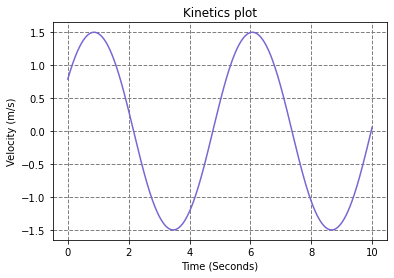

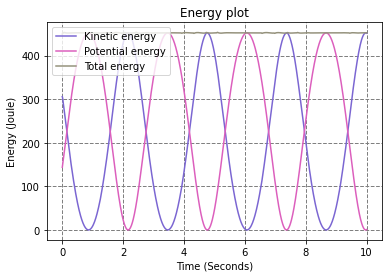

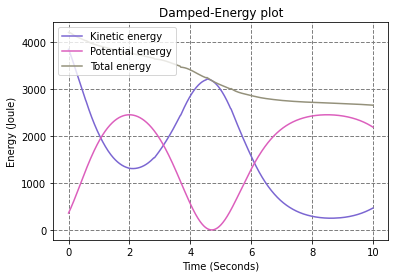

In [5]:
# Simulate conserved pendulum
p1 = Pendulum(5, 10)
p1.solve([np.pi / 4.0, 0.5 * np.pi], 10, 0.01)


# Plot velocity over time
plt.figure()
plt.plot(p1.t, p1.theta)
plt.grid(True, axis="y")
plt.xlabel("Time (Seconds)")
plt.ylabel("Velocity (m/s)")
plt.title("Kinetics plot")
plt.savefig("output/kinetics1")
plt.show()


# Plot conserved energy
plt.figure()
plt.grid(True, axis="y")
plt.plot(p1.t, p1.kinetic)
plt.plot(p1.t, p1.potential)
plt.plot(p1.t, p1.potential + p1.kinetic)
plt.xlabel("Time (Seconds)")
plt.ylabel("Energy (Joule)")
plt.legend(["Kinetic energy", "Potential energy", "Total energy"])
plt.title("Energy plot")
plt.savefig("output/con_energy1")
plt.show()


# Simulate unconserved p1
p2 = DampenedPendulum(5, 25, R=0.25)
p2.solve([np.pi / 4.0, 0.5 * np.pi], 10, 0.01)

# Plot unconserved energy
plt.figure()
plt.grid(True, axis="y")
plt.plot(p2.t, p2.kinetic)
plt.plot(p2.t, p2.potential)
plt.plot(p2.t, p2.potential + p2.kinetic)
plt.xlabel("Time (Seconds)")
plt.ylabel("Energy (Joule)")
plt.legend(["Kinetic energy", "Potential energy", "Total energy"])
plt.title("Damped-Energy plot")
plt.savefig("output/energy1")
plt.show()

In [6]:
class DoublePendulum(object):
    def __init__(self,
                 m1: float = 1.0,
                 l1: float = 1.0,
                 m2: float = 1.0,
                 l2: float = 1.0,
                 constant: float = 9.81):
        """Initialize class object for a Pendulum. l, rod length. m, bob mass."""
        self._m1 = m1
        self._l1 = l1
        self._m2 = m2
        self._l2 = l2
        self._constant = constant

    def __call__(self, t, u):
        """Iterator call object."""
        m1, l1, m2, l2, constant = self._m1, self._l1, self._m2, self._l2, self._constant
        
        (theta1, omega1, theta2, omega2) = u

        dht1, dht2 = omega1, omega2

        dho1 =  ((m2 * l1 * omega1**2 * np.sin(theta2 - theta1))
                * np.cos(theta2 - theta1)
                + (m2 * constant * np.sin(theta2) * np.cos(theta2 - theta1))
                + (m2 * l2 * omega2**2 * np.sin(theta2 - theta1))
                - ((m1 + m2) * constant * np.sin(theta1))) / (((m1 + m2) * l1)
                - (m2 * l1 * np.cos(theta2 - theta1)**2))

        dho2 =  (-(m2 * l1 * omega2**2 * np.sin(theta2 - theta1)
                * np.cos(theta2-theta1))
                + ((m1 + m2) * constant * np.sin(theta1) * np.cos(theta2 - theta1))
                - ((m1 + m2) * l1 * omega1**2 * np.sin(theta2 - theta1))
                - ((m1 + m2) * constant * np.sin(theta2))) / (((m1 + m2) * l2)
                - (m2 * l2 * np.cos(theta2 - theta1)**2))

        return (dht1, dho1, dht2, dho2)


    def solve(self, u0, T, dt, angular_unit: str = "rad"):
        """Solver to find time-series of initial value."""
        if angular_unit == "deg":
            u0 *= np.pi / 180

        t = np.linspace(0, T, int(np.ceil(T / dt)) + 1, dtype=float)
        solution = integrate.solve_ivp(self, [0, T], u0, method="Radau", t_eval=t)

        self._dt = dt
        self._t, self._theta1, self._theta2 = solution.t, solution.y[0], solution.y[2]


    @property
    def t(self):
        return self._t

    @property
    def theta1(self):
        return self._theta1

    @property
    def theta2(self):
        return self._theta2

    @property
    def x1(self):
        return self._l1 * np.sin(self.theta1)

    @property
    def u1(self):
        return -self._l1 * np.cos(self.theta1)

    @property
    def x2(self):
        return self.x1 + self._l2 * np.sin(self.theta2)

    @property
    def u2(self):
        return self.u1 - self._l2 * np.cos(self.theta2)

    @property
    def vx1(self):
        return np.gradient(self.x1, self.t)

    @property
    def vu1(self):
        return np.gradient(self.u1, self.t)

    @property
    def vx2(self):
        return np.gradient(self.x2, self.t)

    @property
    def vu2(self):
        return np.gradient(self.u2, self.t)

    @property
    def potential(self):
        """Calculate potential energy."""
        p1 = self._m1* self._constant * (self.u1 + self._l1)
        p2 = self._m2*self._constant * (self.u2 + self._l1 + self._l2)

        return p1 + p2

    @property
    def kinetic(self):
        """Calculate kinetic energy."""
        k1 = 0.5 * self._m1 * (self.vx1**2 + self.vu1**2)
        k2 = 0.5 * self._m2 * (self.vx2**2 + self.vu2**2)
        
        return k1 + k2


    def animate(self):
        fig = plt.figure()

        plt.axis('equal')
        plt.axis((-7, 7, -7, 7))
        plt.grid(False)

        self.pendulums, = plt.plot([], [], 'o-', lw=2)

        Animation = animation.FuncAnimation(fig,
                                            self._next_frame,
                                            frames=range(len(self.x1)),
                                            repeat=None,
                                            interval=100*self._dt,
                                            blit=True)

        Animation.save("output/example_simulation.mp4", fps=30)


    def _next_frame(self, i):
        self.pendulums.set_data((0, self.x1[i], self.x2[i]),
                                (0, self.u1[i], self.u2[i]))
        return self.pendulums,

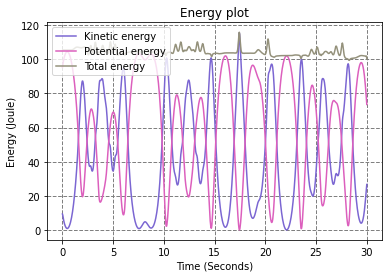

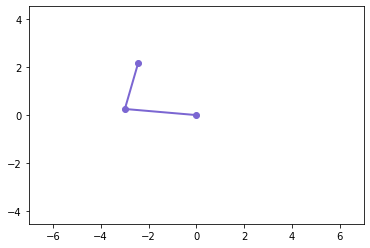

In [7]:
doublePendulum = DoublePendulum(1.2, 3, 0.5, 2)
doublePendulum.solve([3 * np.pi / 4.0, np.pi / 3.0, 0.5 * np.pi, 0.2 * np.pi], 30, 1/30)

plt.plot(doublePendulum.t, doublePendulum.kinetic)
plt.plot(doublePendulum.t, doublePendulum.potential)
plt.plot(doublePendulum.t, doublePendulum.potential + doublePendulum.kinetic)
plt.xlabel("Time (Seconds)")
plt.ylabel("Energy (Joule)")
plt.legend(["Kinetic energy", "Potential energy", "Total energy"])
plt.title("Energy plot")
plt.savefig("output/energy2")
plt.show()

doublePendulum.animate()

In [8]:
def test_double_pendulum():
    l1 = 2
    m1 = 1
    l2 = 1
    m2 = 4
    omega1 = 0.1
    theta1 = np.pi / 4
    omega2 = 0.5
    theta2 = np.pi / 2
    u = (theta1, omega1, theta2, omega2)
    t = 1
    exp_derivative = DoublePendulum(m1, l1, m2, l2, 9.81)

    expected = (0.1, -1.03160179038, 0.5, -8.53190355937 )
    actual = exp_derivative(t, u)

    for ex, ac in zip(expected, actual):
        nt.assert_almost_equals(ex, ac, places=3)


def test_double_pendulum_at_rest():
    l1 = 2
    m1 = 1
    l2 = 1
    m2 = 4

    omega1 = omega2 = theta1 = theta2 = 0

    u = (theta1, omega1, theta2, omega2)
    t = 1

    exp_derivative = DoublePendulum(m1, l1, m2, l2, 9.81)
    
    nt.assert_equal(exp_derivative(t, u), (0,0,0, 0))


def test_potential_energy():
    l1 = 3
    m1 = 1.2
    l2 = 0.5
    m2 = 2

    omega1 = 0.5
    theta1 = np.pi / 4
    omega2 = 0.2
    theta2 = np.pi / 3
    
    u = (theta1, omega1, theta2, omega2)
    t = 1
    
    doublePendulum = DoublePendulum(m1, l1, m2, l2, 9.81)
    doublePendulum.solve([np.pi / 4.0, 1, np.pi / 3.0, 0.2 * np.pi], 10, 1/60)
    
    potensial = doublePendulum.potential[0]
    
    expected = 32.488511775
    actual = potensial

    nt.assert_almost_equals(expected, actual, places=3)


def test_kinetic_energy():
    l1 = 3
    m1 = 1.2
    l2 = 0.5
    m2 = 2

    omega1 = 0.5
    theta1 = np.pi / 4
    omega2 = 0.2
    theta2 = np.pi / 3
    
    u = (theta1, omega1, theta2, omega2)
    t = 1
    
    doublePendulum = DoublePendulum(m1, l1, m2, l2, 9.81)
    doublePendulum.solve([np.pi / 4.0, 1, np.pi / 3.0, 0.2 * np.pi], 10, 1/60)
    
    kinetisk = doublePendulum.kinetic[0]
    
    expected = 15.707571507194
    actual = kinetisk
    
    nt.assert_almost_equals(expected, actual, places=3)


def test_total_energy():
    l1 = 3
    m1 = 1.2
    l2 = 0.5
    m2 = 2

    omega1 = 0.5
    theta1 = np.pi / 4
    omega2 = 0.2
    theta2 = np.pi / 3

    u = (theta1, omega1, theta2, omega2)
    t = 1
    
    doublePendulum = DoublePendulum(m1, l1, m2, l2, 9.81)
    doublePendulum.solve([np.pi / 4.0, 1, np.pi / 3.0, 0.2 * np.pi], 10, 1/60)
    
    total = doublePendulum.potential[0] + doublePendulum.kinetic[0]
    
    expected = 48.196083282170
    actual = total
    
    nt.assert_almost_equals(expected, actual, places=3)


test_double_pendulum()
test_double_pendulum_at_rest()
test_potential_energy()
test_kinetic_energy()
test_total_energy()

In [9]:
class ExponentialDecay():
    def __init__(self, a):
        """Initialize class with decay constant."""
        self._a = a

    def __call__(self, t, u):
        """Call class with variables."""
        return -self._a * u

    def solve(self, u0, T, dt):
        """Class function solve for initial condition."""
        t = np.linspace(0, T, int(np.ceil(T / dt)) + 1, dtype=float)
        solution = integrate.solve_ivp(self, [0, T], u0, t_eval=t)

        return solution.t, solution.y[0]

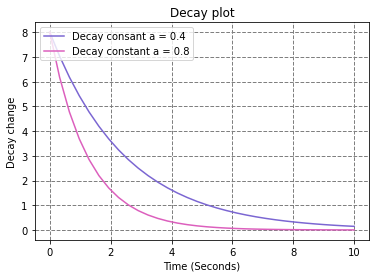

In [10]:
# Calculate decay
a1, a2, u0, T, dt = 0.4, 0.8, [8], 10, 0.33

decay_model1 = ExponentialDecay(a1)
t1, u1 = decay_model1.solve(u0, T, dt)

decay_model2 = ExponentialDecay(a2)
t2, u2 = decay_model2.solve(u0, T, dt)

# Plot exponential decay
plt.figure()
plt.grid(True, axis="y")
plt.plot(t1, u1)
plt.plot(t2, u2)
plt.xlabel("Time (Seconds)")
plt.ylabel("Decay change")
plt.title("Decay plot")
plt.legend(["Decay consant a = 0.4", "Decay constant a = 0.8"])
plt.savefig("output/decay")
plt.show()

In [11]:
def test_derivative():
    a = 0.4
    u = 3.2
    t = 1
    exp_val = ExponentialDecay(a)
    nt.assert_almost_equal(exp_val(t,u), -1.28)

test_derivative()